# Locating Nearest Facility with Origin-Destination Matrix


## Overview 

This tutorial is based on [Locating Nearest Facility with Origin-Destination Matrix (QGIS3)](https://www.qgistutorials.com/en/docs/3/origin_destination_matrix.html).

We will take 2 layers for Washington DC - one with points representing addresses and another with points representing mental health facilities - and find out the facility with the least travel distance from each address using the [OpenRouteService (ORS) Distance Matrix API](https://openrouteservice.org/dev/#/api-docs/v2/matrix).

Input Layers:

* `Address_Points.zip`: A shapefile with locations of randomly selected 100 addresses.
* `Adult_Mental_Health_Providers.zip`: A shapefile with  locations of Adult Mental Health Providers

Output:
* `matrix.gpkg`: A GeoPackage containing the name and coordinates of the nearest health facility for each address.

Data Credit: District of Columbia [Open Data Catalog](https://opendata.dc.gov/). Accessed: August 2019

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !apt install libspatialindex-dev -qq
    !pip install fiona shapely pyproj rtree --quiet
    !pip install geopandas --quiet
    !pip install contextily

In [ ]:
import os
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from shapely.geometry import Point, LineString


In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/spatialthoughts/python-tutorials/raw/main/data/' +
         'Address_Points.zip')
download('https://github.com/spatialthoughts/python-tutorials/raw/main/data/' +
         'Adult_Mental_Health_Providers.zip')

Visit [OpenRouteService Sign-up page](https://openrouteservice.org/dev/#/signup) and create an account. Once your account is activated, visit your Dashboard and request a token. Select `Standard` as the Token type and enter `python` as the Token name. Click *CREATE TOKEN*. Once created, copy the long string displayed under Key and enter below.

In [ ]:
ORS_API_KEY = 'replace this with your key'

## Procedure

Read the `Adult_Mental_Health_Providers.zip` file and convert it to a GeoDataFrame.

In [ ]:
health_shp = 'Adult_Mental_Health_Providers.zip'
health_shp_path = os.path.join(data_folder, health_shp)
health_gdf = gpd.read_file(health_shp_path) 
health_gdf

Read the `Address_Points.zip` file and convert it to a GeoDataFrame.

In [ ]:
address_shp = 'Address_Points.zip'
adddress_shp_path = os.path.join(data_folder, address_shp)
address_gdf = gpd.read_file(adddress_shp_path) 
address_gdf

Let's visualize the locations.

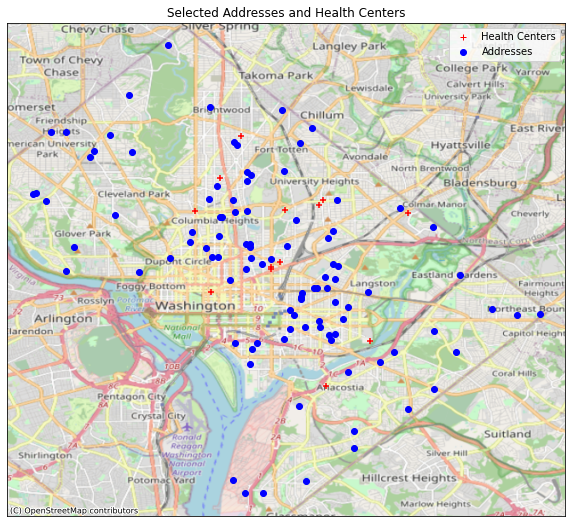

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
address_gdf.plot(ax=ax, color='blue', alpha=1, marker='o')
health_gdf.plot(ax=ax, color='red', alpha=1, marker='+')
cx.add_basemap(ax, crs=health_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)

legend_elements = [
    plt.plot([],[], color='red', alpha=1, marker='+', label='Health Centers', ls='')[0],
    plt.plot([],[], color='blue', alpha=1, marker='o', label='Addresses', ls='')[0]]
ax.legend(handles=legend_elements, loc='upper right')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Selected Addresses and Health Centers')

plt.show()

To standardize the workflow, we rename the dataframes to appropriate names and select the attribute containing the names we want in the output. You should change it to match your datasets.

In [ ]:
origin_gdf = address_gdf
origin_name_column = 'OBJECTID_1'
destination_gdf = health_gdf
destination_name_column = 'NAME'

The [ORS Distance Matrix API](https://openrouteservice.org/dev/#/api-docs/matrix) needs a list of locations in the (longitude,latitude) format. We take the geometry column from the GeoDataFrame and create the list.

In [ ]:
origins = list(zip(origin_gdf.geometry.x, origin_gdf.geometry.y))
destinations = list(zip(destination_gdf.geometry.x, destination_gdf.geometry.y))

In [ ]:
locations = origins + destinations

Another parameter required by the API are the list of indices for origins and destinations. If you want the distances between each location, you can specify `all` instead of the list of indices.

In [ ]:
origins_index = list(range(0, len(origins)))
destinations_index = list(range(len(origins), len(locations)))

In [ ]:
body = {'locations': locations,
       'destinations': destinations_index,
       'sources': origins_index,
       'metrics': ['distance']}

headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': ORS_API_KEY,
    'Content-Type': 'application/json; charset=utf-8'
}

response = requests.post('https://api.openrouteservice.org/v2/matrix/driving-car', json=body, headers=headers)


In [ ]:
distances = response.json()['distances']
distances

The response contains the list of distances from each origin to each destination. We iterate over each origin and extract the minimum distance and the destination coordinate. We reverse lookup the coordinate from the destination dataframe and extract the name of the destination.

In [ ]:
distance_matrix = []
for origin_index, item  in origin_gdf.iterrows():
  origin_name = item[origin_name_column]
  origin_x = item.geometry.x
  origin_y = item.geometry.y
  origin_distances = distances[origin_index]
  # We find the minimum distance and the index of the minimum distance
  min_distance = min(origin_distances)
  min_index = origin_distances.index(min_distance)
  destination_index = destinations_index[min_index]
  destination_x, destination_y = locations[destination_index]
  filtered = health_gdf[(destination_gdf.geometry.x == destination_x) & (destination_gdf.geometry.y == destination_y) ]
  destination_row = filtered.iloc[0]
  destination_name = destination_row[destination_name_column]

  distance_matrix.append(
    [origin_name, origin_y, origin_x, destination_name, destination_y, destination_x, min_distance])

Now we are a list of items. We create a Pandas DataFrame from it.

In [ ]:
matrix_df = pd.DataFrame(distance_matrix, 
                  columns =['origin_name', 'origin_y', 'origin_x', 'destination_name', 'destination_y', 'destination_x', 'distance'])
matrix_df

To visualize and validate the results, let's create a line connecting the origin and destination that we can plot on a map.

In [ ]:
def create_line(row):
  origin_point = Point(row['origin_x'], row['origin_y'])
  destination_point = Point(row['destination_x'], row['destination_y'])
  return LineString([origin_point, destination_point])

geometry = matrix_df.apply(create_line, axis=1)

matrix_gdf = gpd.GeoDataFrame(matrix_df, geometry=geometry, crs='EPSG:4326')
matrix_gdf

Visualize the results

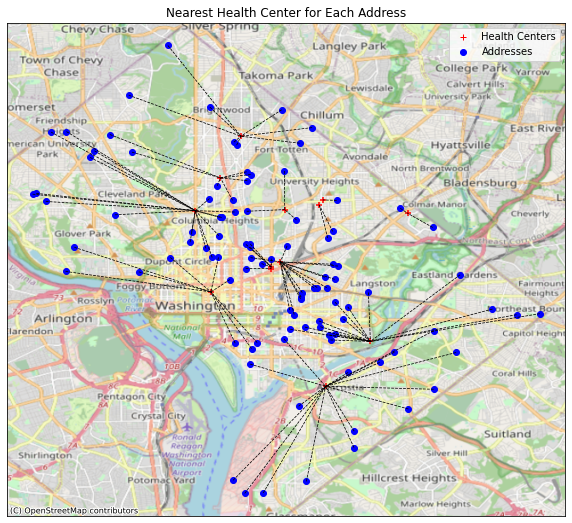

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
address_gdf.plot(ax=ax, color='blue', alpha=1, marker='o')
matrix_gdf.plot(ax=ax, color='black', linestyle='--', linewidth=0.75)
health_gdf.plot(ax=ax, color='red', alpha=1, marker='+')

cx.add_basemap(ax, crs=health_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)

legend_elements = [
    plt.plot([],[], color='red', alpha=1, marker='+', label='Health Centers', ls='')[0],
    plt.plot([],[], color='blue', alpha=1, marker='o', label='Addresses', ls='')[0]]
ax.legend(handles=legend_elements, loc='upper right')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Nearest Health Center for Each Address')
plt.show()

Save the results.

In [ ]:
output_file = 'matrix.gpkg'
output_path = os.path.join(output_folder, output_file)

origin_gdf.to_file(driver='GPKG', filename=output_path, layer='origins')
destination_gdf.to_file(driver='GPKG', filename=output_path, layer='destinations')
matrix_gdf.to_file(driver='GPKG', filename=output_path, layer='distance_matrix')